# Multi-class Classification with Deep NNs

In this notebook, we will train different Neural Network models for classification purposes. We will vary the model's parameters to select the best configuration, namely the one with the highest performance

<h2>Preparation</h2>


We'll need the following libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader
from itertools import product
import copy

torch.manual_seed(1)
np.random.seed(1)

As the name suggests, the function <code>plot_decision_regions_3class</code> will be used to plot the resulting decision region of the model

In [2]:
def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label='y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label='y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label='y=2')
    plt.title("decision region")
    plt.legend()

In [3]:
def plot_accuracy(loss, acc, title=""):
    fig, ax1 = plt.subplots(figsize=(4, 3))
    color = 'tab:red'
    ax1.plot(loss, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    ax1.title.set_text("Configuration " + title)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(acc, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

    plt.show()

## Dataset

The following dataset is a modified version of the dataset found on http://cs231n.github.io/neural-networks-case-study. In this case "K" corresponds to the number of classes in our data, while "N" references the number of data points per class

In [4]:
class Data(Dataset):
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D))
        y = np.zeros(N * K, dtype='uint8')  # class labels

        for j in range(K):
            ix = range(N * j, N * (j + 1))
            r = np.linspace(0.0, 1, N)  # radius
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
            y[ix] = j

        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

    def plot_data(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y=1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go',label="y=2")
        plt.legend()

<!--Empty Space for separating topics-->


## Building the Model

We will create a custom NN module using <code>ModuleList()</code> that will contain a variable amount of hidden layers, specified by the user.   
Moreover, we will use the regularization technique called **Dropout**, which randomly deactivates a set of neurons in every forward pass during training. This technique helps avoid overfitting, although in this particular case it may not be necessary

In [5]:
class Net(nn.Module):
    def __init__(self, Layers, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(self.drop(linear_transform(activation)))
            else:
                activation = linear_transform(activation)
        return activation

The following method will train the model

In [6]:
def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        LOSS.append(loss.item())
        ACC.append(accuracy(model, data_set))

    results = {"Loss": LOSS, "Accuracy": ACC}
    return results

Here we define a custom function to calculate accuracy

In [7]:
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

## Training

Lets create and visualize our dataset

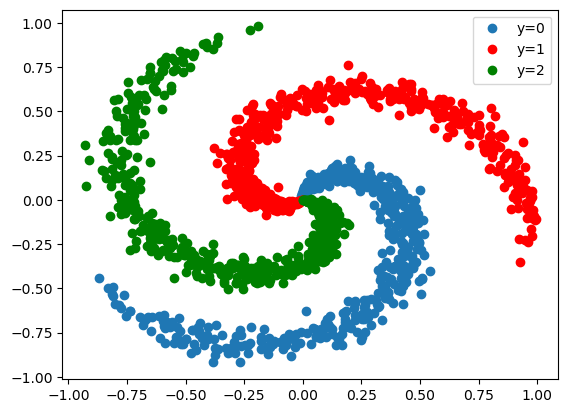

In [8]:
data_set = Data()
data_set.plot_data()
data_set.y = data_set.y.view(-1)

The following dictionary will contain different cost and  accuracy values for each epoch for different parameter values

In [9]:
Results = {"1": {"Loss": 0, "Accuracy:": 0}, "2": {"Loss": 0, "Accuracy:": 0}}

Lets define the parameters to be used by our model. Here we will specify different values for parameters like **momentum** or **layers** in the network and iterate over every possible combination to determine the optimal one

In [10]:
momentums = [0., 0.2, 0.5]
drop_proba = [0., 0.5]
learning_rates = [0.01]
layers = [[2, 10, 10, 3], [2, 50, 3]]
params_combination = list(product(momentums, drop_proba, learning_rates, layers))

train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
epochs = 400

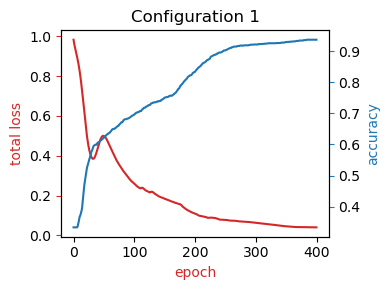

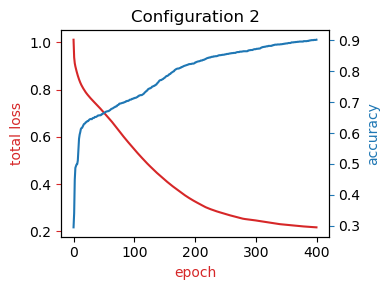

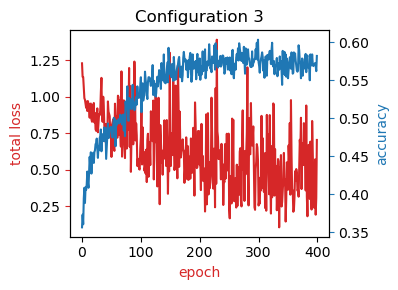

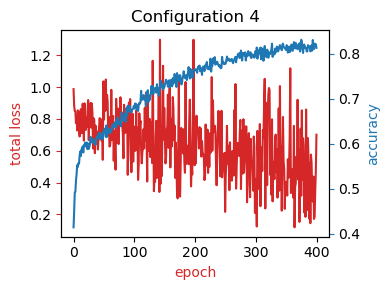

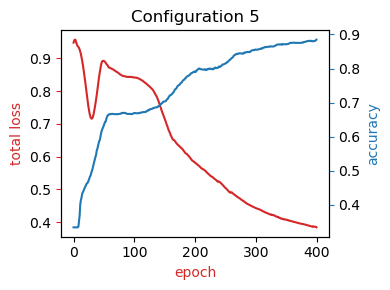

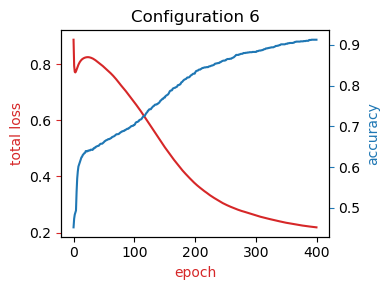

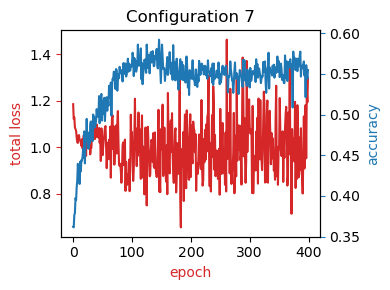

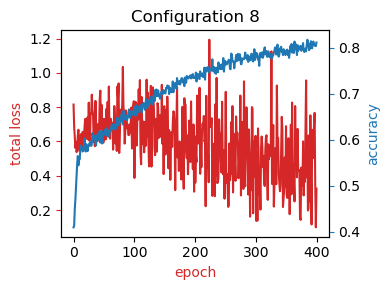

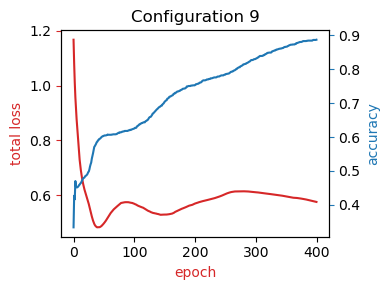

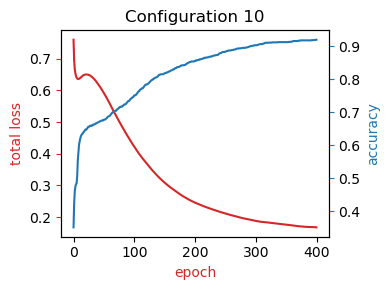

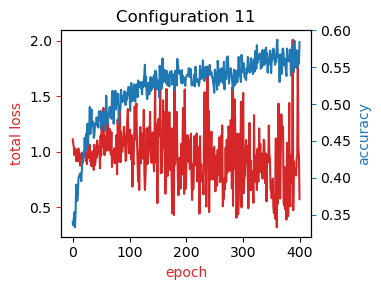

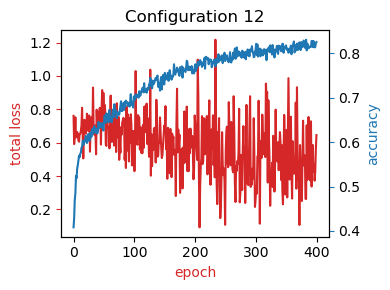

In [11]:
max_acccuracy = 0.
for index, params in enumerate(params_combination):
    momentum, dropout, learning_rate, layer = params
    model = Net(layer, p=dropout)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    results = train(data_set, model, criterion, train_loader, optimizer, epochs=epochs)
    if max_acccuracy < results["Accuracy"][-1]:
        max_acccuracy = results["Accuracy"][-1]
        state = copy.deepcopy(model.state_dict())
        torch.save(state, 'model.pth')
    title = str(index+1)
    Results[title] = results
    plot_accuracy(results["Loss"], results["Accuracy"], title)

In [12]:
max_accuracy_config = max(Results, key=lambda k: Results[k]["Accuracy"][-1])
element_with_max_accuracy = Results[max_accuracy_config]
print("Configuration " + str(max_accuracy_config) + " has the highest accuracy of: "
      + str(element_with_max_accuracy["Accuracy"][-1]))

momentum, dropout, learning_rate, layer = params_combination[int(max_accuracy_config)-1]
print("Parameters")
print('Momentum: {}\nDropout probabiliy: {}\nLearning Rate: {}\nLayers: {}'
      .format(momentum, dropout, learning_rate, layer))

Configuration 1 has the highest accuracy of: 0.9366666666666666
Parameters
Momentum: 0.0
Dropout probabiliy: 0.0
Learning Rate: 0.01
Layers: [2, 10, 10, 3]


In [13]:
min_accuracy_config = min(Results, key=lambda k: Results[k]["Accuracy"][-1])
element_with_min_accuracy = Results[min_accuracy_config]
print("Configuration " + str(min_accuracy_config) + " has the lowest accuracy of: "
      + str(element_with_min_accuracy["Accuracy"][-1]))

momentum, dropout, learning_rate, layer = params_combination[int(min_accuracy_config)-1]
print("Parameters")
print('Momentum: {}\nDropout probabiliy: {}\nLearning Rate: {}\nLayers: {}'
      .format(momentum, dropout, learning_rate, layer))

Configuration 7 has the lowest accuracy of: 0.5546666666666666
Parameters
Momentum: 0.2
Dropout probabiliy: 0.5
Learning Rate: 0.01
Layers: [2, 10, 10, 3]


In [14]:
model = Net(layer, p=dropout)
model.load_state_dict(torch.load('model.pth'))
print(model.state_dict())

OrderedDict([('hidden.0.weight', tensor([[ 2.7772e+00, -5.0601e-01],
        [-1.3708e-01,  3.3189e-01],
        [-2.2327e+00,  2.3449e+00],
        [-5.0039e-01,  8.6191e-01],
        [ 9.8300e-02, -8.6581e-02],
        [ 1.6707e+00,  7.2629e-01],
        [ 2.6837e+00,  1.1605e-01],
        [-8.9609e-01, -2.1794e+00],
        [ 1.0249e-01, -2.8248e-03],
        [-1.0665e+00,  2.8900e+00]])), ('hidden.0.bias', tensor([-0.4282, -0.4271, -0.5289, -0.4395, -0.2266, -0.3095,  0.3172, -0.8064,
        -0.6912,  0.5354])), ('hidden.1.weight', tensor([[ 0.2331,  0.3000,  0.2440, -0.2881, -0.3007, -0.2188,  0.4755,  0.5483,
          0.1353, -0.1342],
        [-0.4317, -0.1338,  1.7147,  0.3564, -0.1666,  0.2443, -0.2401, -0.5824,
         -0.0913, -0.8176],
        [-1.1396, -0.1508,  1.8438,  0.3347,  0.3150,  0.2633,  0.0064, -0.8439,
          0.1926, -1.2419],
        [-1.6428,  0.2054,  1.0154,  0.7624, -0.1773, -1.4434,  1.9073,  1.1399,
         -0.2400, -0.5529],
        [ 1.4945, -0.

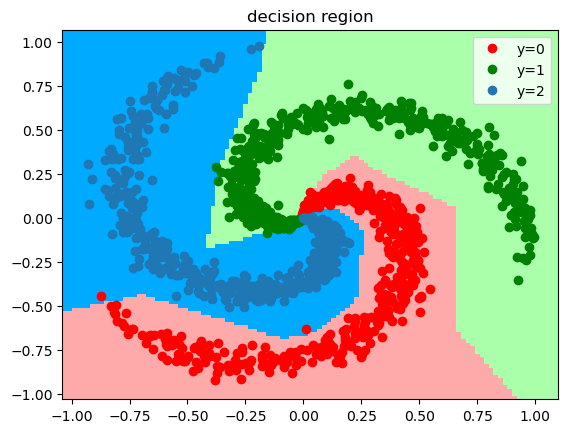

In [15]:
model.eval()
plot_decision_regions_3class(model, data_set)

## Comparing results

The plot below compares results from the 5 best performing configurations

In [16]:
sorted_configurations = sorted(Results.items(), key=lambda item: item[1]["Accuracy"][-1], reverse=True)
top_five_configurations = sorted_configurations[:5]

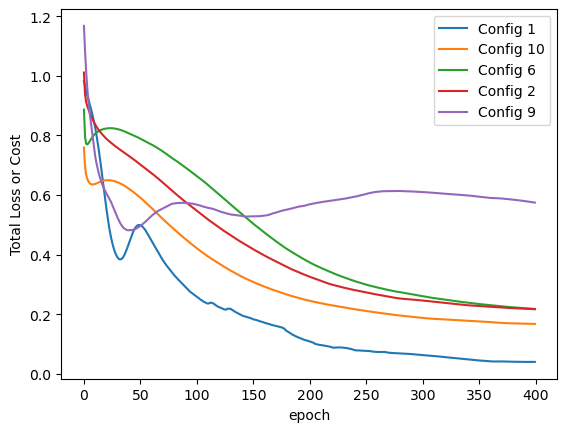

In [17]:
for key, value in top_five_configurations:
    plt.plot(value['Loss'], label="Config " + key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

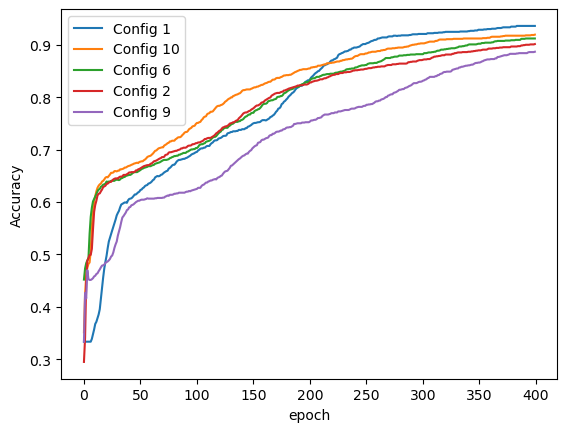

In [18]:
for key, value in top_five_configurations:
    plt.plot(value['Accuracy'], label="Config " + key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')